<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

#  Classification Metics & Class Imbalance 2: Modeling

_Author_: Dan Wilhelm (LA)
    
---

Today we'll cover techniques for:

- Organizing larger projects.
- Handling class imbalance.
- Optimizing models for precision/recall rather than accuracy.

Because this is a larger project than usual, there is no solution notebook. All code is contained inside the lesson notebooks.

# Lesson Outline (Continued)

1. [Loading Results from Another Notebook](#load)
2. [Baseline Models](#models)
    - [Dummy Classifier](#dummy)
    - [Logistic Regression](#logistic)
    - [Random Forests](#rfs)
    - [Nearest Neighbors](#nn)
3. [Class Imbalance Techniques](#imbalance)
    - [Undersample More Frequent Class](#undersample)
    - [Oversample Less Frequent Class](#oversample)
    - [SMOTE (Synthetic Minority Over-sampling Technique)](#smote)
    - [Weight each class in the models](#weight)
    - [Adjust the class cutoff threshold (ROC)](#roc)
4. [Next Steps](#next)

In [20]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline


# CONSTANTS

# We might normally store this in a shared external Python file
INPUT_PICKLE_FILE = 'adult_data-vec.pickle'

--- 
<a id="load"></a>

# Loading Results from Another Notebook

Let's use `pickle` again to load our last results from disk.

In [21]:
pd.read_pickle('y_test.pkl')

0        <=50K
1        <=50K
2         >50K
3         >50K
5        <=50K
         ...  
16275    <=50K
16276    <=50K
16278    <=50K
16279    <=50K
16280     >50K
Name: income, Length: 15060, dtype: object

In [22]:
import pickle

# We might normally store this in a shared external Python file
def load_adult_pickle(filename, verbose=False):
    """ Load train/test data from pickled file. """
    if verbose:
        print(f'Loading from "{filename}" ...')

    # 'rb' - Read + Binary File
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    if verbose:
        print(f'\tImported vectorized training data from "{data["train_file"]}".')
        print(f'\tImported vectorized test data from "{data["test_file"]}".\n')

        print(f'Data keys: {list(data.keys())}\n')
    
    return data['X_train_df'], data['y_train'], data['X_test_df'], data['y_test']

In [23]:
X_train_df, y_train, X_test_df, y_test = \
    load_adult_pickle(INPUT_PICKLE_FILE, verbose=True)

print(f'Train: {X_train_df.shape}, {y_train.shape}')
print(f'Test: {X_test_df.shape}, {y_test.shape}')

Loading from "adult_data-vec.pickle" ...
	Imported vectorized training data from "./data/adult.data".
	Imported vectorized test data from "./data/adult.test".

Data keys: ['train_file', 'test_file', 'encoders', 'X_train_df', 'y_train', 'X_test_df', 'y_test']

Train: (30162, 104), (30162,)
Test: (15060, 104), (15060,)


---

<a id="models"></a>
# Baseline Models
Never just give a single accuracy or error value! Always compare your model's with other models, including a baseline.

The baseline model is typically the simplest model -- i.e. always predict the most common class.


<a id="dummy"></a>
# Baseline 1: Null Model

In [24]:
print('\ny_train Class Distribution: \n', y_train.value_counts(normalize=True))

print('\ny_test Class Distribution: \n', y_test.value_counts(normalize=True))


y_train Class Distribution: 
 <=50K    0.751078
>50K     0.248922
Name: income, dtype: float64

y_test Class Distribution: 
 <=50K    0.754316
>50K     0.245684
Name: income, dtype: float64


This indicates our test set has about the same distribution of target classes.

So, the null model should perform approximately the same on both since it just predicts `<=50K` each time.

In [25]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier(strategy='most_frequent')
dc.fit(X_train_df, y_train)

y_pred_train = dc.predict(X_train_df)
y_pred_test = dc.predict(X_test_df)

print('Train Accuracy: ', accuracy_score(y_train, y_pred_train))
print('Test Accuracy: ', accuracy_score(y_test, y_pred_test))

Train Accuracy:  0.7510775147536636
Test Accuracy:  0.7543160690571049


<a id="logistic"></a>
# Model: Logistic Regression

This model typically doesn't have as high accuracy as others, but it is great for its interpretability.

In [26]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train_df, y_train)

y_pred_train = lr.predict(X_train_df)
y_pred_test = lr.predict(X_test_df)

print('Train Accuracy: ', accuracy_score(y_train, y_pred_train))
print('Test Accuracy: ', accuracy_score(y_test, y_pred_test))

Train Accuracy:  0.7902990517870168
Test Accuracy:  0.7926958831341302


<details><summary>Q: How does this compare to the dummy classifier?</summary>
The accuracy is only slightly higher than baseline. :(
</details>

Did we fare better with our precision and recall?

In [27]:
# Confusion matrix

print('Order of classes: ', lr.classes_)

confusion_df = pd.DataFrame(
                    data=confusion_matrix(y_test, y_pred_test),
                    index=[f'actual {target_class}' for target_class in lr.classes_],
                    columns=[f'predicted {target_class}' for target_class in lr.classes_])

print('\nTest Confusion Matrix: \n', confusion_df)

Order of classes:  ['<=50K' '>50K']

Test Confusion Matrix: 
               predicted <=50K  predicted >50K
actual <=50K            10946             414
actual >50K              2708             992


So, we see that our initial model makes few false positives and many false negatives.

From this table, we can also derive the classification report.

In [28]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       <=50K       0.80      0.96      0.88     11360
        >50K       0.71      0.27      0.39      3700

    accuracy                           0.79     15060
   macro avg       0.75      0.62      0.63     15060
weighted avg       0.78      0.79      0.76     15060



Let's interpret the precision and recall:
+ **Recall of `>50K` - 27%**: We only identified 27% of the actual >50K customers! We earlier said this outcome was not preferred.
+ **Precision of `>50K` - 71%**: When we predicted >50K, we got it right 71% of the time. So, 29% of the marketing materials were sent to <=50K. We earlier said this was acceptable, since perhaps they were close to >50K.

Other than that, here are the other terms for the precision column:
+ **Macro avg**: The average of the two precisions.
+ **Weighted avg**: The average of the two precisions, with each weighted by its proportion of samples.

<a id="rfs"></a>
# Baseline 2: Random Forests

Another good starting baseline model for comparison. It typically overfits but performs well with few tweaks.

First, let's take the lengthy analysis above and condense it into a function so we can apply the same to new models:

In [29]:
def run_baseline(mdl, 
                 X_train_df, y_train, X_test_df, y_test,
                 cv=False, cvmean=True, verbose=True):
    """Return a dict of model performance indicators."""
    
    results = {}
    
    if cv:
        # This option is intended to compare with the train-test-split results on test set
        # 1. CV creates its own train/test, so recombine the data (if desired on entire dataset)
        #X = pd.concat((X_train_df, X_test_df))
        #y = pd.concat((y_train, y_test)).replace({'>50K': 1, '<=50K': 0})
        X = X_train_df
        y = y_train.replace({'>50K': 1, '<=50K': 0})

        # 2. Cross-validate
        score_types = ('accuracy', 'recall', 'precision', 'f1')
        cv_results = cross_validate(mdl, X, y, 
                           scoring=score_types, return_train_score=True,
                           cv=KFold(4, shuffle=True))
        
        # Create results with same names as below
        score = 'train_accuracy'
        results[score] = cv_results[score].mean() if cvmean else cv_results[score]
        for score in score_types:
            score = f'test_{score}'
            results[score] = cv_results[score].mean() if cvmean else cv_results[score]
        
    else:
        # 1. Fit the model on the training set
        mdl.fit(X_train_df, y_train)

        # 2. Predict on the training and test sets
        y_pred_train = mdl.predict(X_train_df)
        y_pred_test = mdl.predict(X_test_df)

        # 3. Train & test accuracy
        results['train_accuracy'] = accuracy_score(y_train, y_pred_train)
        results['test_accuracy'] = accuracy_score(y_test, y_pred_test)

        if verbose:
            print('Train Accuracy: ', results['train_accuracy'])
            print('Test Accuracy: ', results['test_accuracy'])
            print('\nOrder of classes: ', lr.classes_)


        # 4. Test confusion matrix
        confusion_df = pd.DataFrame(\
                            data=confusion_matrix(y_test, y_pred_test),
                            index=[f'actual {target_class}' for target_class in lr.classes_],
                            columns=[f'predicted {target_class}' for target_class in lr.classes_])

        if verbose:
            print('\nTest Confusion Matrix: \n', confusion_df)
            print(classification_report(y_test, y_pred_test))

        # 5. Test recall and precision (if no samples, set recall/precision to 0)
        results['test_recall'] = recall_score(y_test, y_pred_test, 
                                              pos_label='>50K', zero_division=0)
        results['test_precision'] = precision_score(y_test, y_pred_test, 
                                                    pos_label='>50K', zero_division=0)
        results['test_f1'] = f1_score(y_test, y_pred_test, 
                                      pos_label='>50K', zero_division=0)
    return results

In [30]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)

# Consistent accuracy scores with `adult.names`!
#   -- C4.5       : 84.46+-0.30   -- ours (below) is ~84.55%
run_baseline(rfc, X_train_df, y_train, X_test_df, y_test)

Train Accuracy:  0.9999336913997745
Test Accuracy:  0.8459495351925631

Order of classes:  ['<=50K' '>50K']

Test Confusion Matrix: 
               predicted <=50K  predicted >50K
actual <=50K            10455             905
actual >50K              1415            2285
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90     11360
        >50K       0.72      0.62      0.66      3700

    accuracy                           0.85     15060
   macro avg       0.80      0.77      0.78     15060
weighted avg       0.84      0.85      0.84     15060



{'train_accuracy': 0.9999336913997745,
 'test_accuracy': 0.8459495351925631,
 'test_recall': 0.6175675675675676,
 'test_precision': 0.7163009404388715,
 'test_f1': 0.6632801161103049}

<details><summary>Q: Did the model overfit? Can you explain its precision and recall values?</summary>
Clearly, overfitting occurred since the training accuracy is nearly 1, yet the test accuracy is only 85%. The recall is 0.62 - double that of logistic regression! So, we now identify 62% of all >50K people correctly. Luckily, the precision did not decrease much at all.
</details>


With random forests, to reduce overfitting we can:

+ Produce shallower trees.
+ Prune the trees more.
+ Use regularization.
+ Use a tree method that optimizes for things other than accuracy.

We can also tweak its recall vs precision by using some of the imbalance techniques below.

<a id="nn"></a>
# Baseline 3: Nearest Neighbor

Nearest neighbor may not perform as well as other models, but it is often used as a baseline for comparing models since it works in a straightforward way. Note that NN has poor interpretability, unless the objective is directly comparing distances between the datapoints!


In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

run_baseline(knn, X_train_df, y_train, X_test_df, y_test)

Train Accuracy:  0.8309462237252172
Test Accuracy:  0.7691235059760956

Order of classes:  ['<=50K' '>50K']

Test Confusion Matrix: 
               predicted <=50K  predicted >50K
actual <=50K            10379             981
actual >50K              2496            1204
              precision    recall  f1-score   support

       <=50K       0.81      0.91      0.86     11360
        >50K       0.55      0.33      0.41      3700

    accuracy                           0.77     15060
   macro avg       0.68      0.62      0.63     15060
weighted avg       0.74      0.77      0.75     15060



{'train_accuracy': 0.8309462237252172,
 'test_accuracy': 0.7691235059760956,
 'test_recall': 0.3254054054054054,
 'test_precision': 0.5510297482837528,
 'test_f1': 0.40917587085811385}

<details><summary>Q: How did this perform? Better or worse than random forests?</summary>
Significantly worse on all metrics!</details>

Of course, we could tweak this model by adjusting `k` and observing the "elbow curve". However, it's unlikely to outperform random forests. 

---

Let's summarize so far:

| Syntax         | Accuracy    | Recall >50k | Precision >50k   | Notes              |
| -----------    | ----------- | ----------- | -----------      |  -----------       |
| Requirements:  | High        | Preferred   | Not as important |                    |
| Null           | 75%         | 0%*         | 0%*              | * never guesses >50 |
| KNN            | 77%         | 33%         | 55%              |                    |
| Logistic Regr  | 79%         | 27%         | 71%              |                    |
| Random Forests | 85%         | 62%         | 72%              |                    |

---
We will be tweaking things that affect all models.

So, let's write a function that generates this chart automatedly!

In [32]:
def test_models(models, X_train_df, y_train, X_test_df, y_test,
                subset=[], cv=False, cvmean=True, verbose=False):
    """Returns DataFrame of baseline results 
       given a dict `models` of names/sklearn models."""
    results = {}
    
    # Fit each model and store how it performs on the test set
    for name,model in models.items():
        if not subset or name in subset:
            if verbose:
                print('\nRunning {} - {}'.format(name, model))

            results[name] = run_baseline(model, 
                                         X_train_df, y_train, 
                                         X_test_df, y_test,
                                         cv=cv, cvmean=cvmean,
                                         verbose=False)
            if verbose:
                print('Results: ', results[name])

    return pd.DataFrame.from_dict(results, orient='index').sort_index()

In [33]:
# Let's try to duplicate the earlier chart we manually compiled!
# Ignore the warning --
#    the DummyClassifier doesn't have a precision score since one class is never predicted.

models = {'Most Frequent': DummyClassifier(strategy='most_frequent'),
          'Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
          'Random Forest': RandomForestClassifier(n_estimators=100),
          'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=10000)}

model_results = test_models(models, 
                            X_train_df, y_train, 
                            X_test_df, y_test,
                            cv=True, verbose=True)

model_results


Running Most Frequent - DummyClassifier(strategy='most_frequent')
Results:  {'train_accuracy': 0.7510775224486433, 'test_accuracy': 0.7510775840084812, 'test_recall': 0.0, 'test_precision': 0.0, 'test_f1': 0.0}

Running Nearest Neighbors - KNeighborsClassifier()


C:\Users\614318\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results:  {'train_accuracy': 0.8274981971920309, 'test_accuracy': 0.7652014258393638, 'test_recall': 0.31752695200792724, 'test_precision': 0.549199483035557, 'test_f1': 0.40233090878393074}

Running Random Forest - RandomForestClassifier()
Results:  {'train_accuracy': 0.9999226402106343, 'test_accuracy': 0.8495126728965651, 'test_recall': 0.626269142786978, 'test_precision': 0.7309222269546944, 'test_f1': 0.674475192823835}

Running Logistic Regression - LogisticRegression(max_iter=10000)
Results:  {'train_accuracy': 0.7906416339058178, 'test_accuracy': 0.7908957777060996, 'test_recall': 0.26657268983416005, 'test_precision': 0.7147317307268334, 'test_f1': 0.3881699515052606}


,train_accuracy,test_accuracy,test_recall,test_precision,test_f1
Logistic Regression,0.790642,0.790896,0.266573,0.714732,0.388170
Most Frequent,0.751078,0.751078,0.000000,0.000000,0.000000
Nearest Neighbors,0.827498,0.765201,0.317527,0.549199,0.402331
Random Forest,0.999923,0.849513,0.626269,0.730922,0.674475


So far, this looks good. However, while the accuracy is high, our recall is still low.

Out of all >50K households, we only correctly identify 61%!

Let's try to improve the recall.

---
<a id="imbalance"></a>
# Class Imbalance Techniques

Our goal is to improve the recall on our test set without impacting precision much.

<a id="undersample"></a>
# Imbalance Technique 1: Undersample More Frequent Class

For resampling our training set, we will use the library `imbalanced-learn`.

See: https://imbalanced-learn.org/stable/user_guide.html

Install it using: `conda install -c conda-forge imbalanced-learn`

In [34]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

In [35]:
def print_sampling_stats(X_train_df, X_train_sampled,
                         y_train, y_train_sampled,
                         y_test):
    
    print('Original dataset classes: {}'.format(Counter(y_train)))
    print('Resampled dataset classes: {}'.format(Counter(y_train_sampled)))
    print()
    print('Test dataset classes still the same to model real world: {}'.format(Counter(y_test)))

    print()
    print('X_train shape (under/reg): ', X_train_sampled.shape, X_train_df.shape)
    print('y_train shape (under/reg): ', y_train_sampled.shape, y_train.shape)
    print('X_test, shape y_test: ', X_test_df.shape, y_test.shape)

In [39]:
nm = RandomUnderSampler()

X_train_under, y_train_under = nm.fit_resample(X_train_df, y_train)

print_sampling_stats(X_train_df, X_train_under,
                     y_train, y_train_under,
                     y_test)

Original dataset classes: Counter({'<=50K': 22654, '>50K': 7508})
Resampled dataset classes: Counter({'<=50K': 7508, '>50K': 7508})

Test dataset classes still the same to model real world: Counter({'<=50K': 11360, '>50K': 3700})

X_train shape (under/reg):  (15016, 104) (30162, 104)
y_train shape (under/reg):  (15016,) (30162,)
X_test, shape y_test:  (15060, 104) (15060,)


In [40]:
# Let's see how we did!

undersample_results = test_models(models, 
                                  X_train_under, y_train_under, 
                                  X_test_df, y_test, 
                                  subset=('Random Forest'),
                                  verbose=False)

print('DONE!')

DONE!


In [41]:
# Original
print('Original')
model_results

Original


,train_accuracy,test_accuracy,test_recall,test_precision,test_f1
Logistic Regression,0.790642,0.790896,0.266573,0.714732,0.388170
Most Frequent,0.751078,0.751078,0.000000,0.000000,0.000000
Nearest Neighbors,0.827498,0.765201,0.317527,0.549199,0.402331
Random Forest,0.999923,0.849513,0.626269,0.730922,0.674475


In [42]:
# Undersample
print('Undersample')
undersample_results

Undersample


,train_accuracy,test_accuracy,test_recall,test_precision,test_f1
Random Forest,1.0,0.806175,0.822162,0.573638,0.675775


<details><summary>Q: How did undersampling perform vs. baseline?</summary>
For Random Forests, the `test_recall` increased significantly.

But:
   + At the expense of overall accuracy.
   + At the expense of precision.</details>



> Note: There are smarter ways of undersampling than random! For example, see the [NearMiss](https://imbalanced-learn.org/stable/generated/imblearn.under_sampling.NearMiss.html?highlight=nearmiss) undersampler. For example, it can use nearest neighbors to selectively sample only the points nearest to those in the majority class. Here are some [illustrations](https://imbalanced-learn.org/stable/auto_examples/under-sampling/plot_illustration_nearmiss.html?highlight=nearmiss) of the three strategies it supports.

<a id="oversample"></a>
# Imbalance Technique 2: Oversample Less Frequent Class

Chooses new samples at random with replacement.

We might predict this will perform worse, because one of the classes will contain many repeated members.

In [43]:
ros = RandomOverSampler()

X_train_over, y_train_over = ros.fit_resample(X_train_df, y_train)

print_sampling_stats(X_train_df, X_train_over,
                     y_train, y_train_over,
                     y_test)

Original dataset classes: Counter({'<=50K': 22654, '>50K': 7508})
Resampled dataset classes: Counter({'<=50K': 22654, '>50K': 22654})

Test dataset classes still the same to model real world: Counter({'<=50K': 11360, '>50K': 3700})

X_train shape (under/reg):  (45308, 104) (30162, 104)
y_train shape (under/reg):  (45308,) (30162,)
X_test, shape y_test:  (15060, 104) (15060,)


In [44]:
# Let's see how we did!

oversample_results = test_models(models, 
                                 X_train_over, y_train_over, 
                                 X_test_df, y_test, 
                                 subset=('Random Forest'),
                                 verbose=False)

print('DONE!')

DONE!


In [45]:
# Original
print('Original')
model_results

Original


,train_accuracy,test_accuracy,test_recall,test_precision,test_f1
Logistic Regression,0.790642,0.790896,0.266573,0.714732,0.388170
Most Frequent,0.751078,0.751078,0.000000,0.000000,0.000000
Nearest Neighbors,0.827498,0.765201,0.317527,0.549199,0.402331
Random Forest,0.999923,0.849513,0.626269,0.730922,0.674475


In [48]:
# Oversample
print('Oversample')
oversample_results

Oversample


,train_accuracy,test_accuracy,test_recall,test_precision,test_f1
Random Forest,0.999978,0.838579,0.676757,0.669698,0.673209


In [49]:
# Undersample
print('Undersample')
undersample_results

Undersample


,train_accuracy,test_accuracy,test_recall,test_precision,test_f1
Random Forest,1.0,0.806175,0.822162,0.573638,0.675775


<details><summary>Q: How did oversampling perform?</summary>
Compared to the original Random Forest, the accuracy did not change. The recall is slightly better (now 68%, orig 62%) while precision slightly worse (now 67%, orig 72%). 

This model could be considered slightly better with minimal downside.</details

<a id="smote"></a>
# Imbalance Technique 3: SMOTE (Synthetic Minority Over-sampling Technique)

This technique does not just randomly oversample with replacement. Instead, it uses nearest neighbors to synthetically create fake datapoints to use for oversampling.

In [50]:
smo = SMOTE()

X_train_smote, y_train_smote = smo.fit_resample(X_train_df, y_train)

print_sampling_stats(X_train_df, X_train_smote,
                     y_train, y_train_smote,
                     y_test)

Original dataset classes: Counter({'<=50K': 22654, '>50K': 7508})
Resampled dataset classes: Counter({'<=50K': 22654, '>50K': 22654})

Test dataset classes still the same to model real world: Counter({'<=50K': 11360, '>50K': 3700})

X_train shape (under/reg):  (45308, 104) (30162, 104)
y_train shape (under/reg):  (45308,) (30162,)
X_test, shape y_test:  (15060, 104) (15060,)


In [51]:
# Let's see how we did!

smote_results = test_models(models, 
                            X_train_over, y_train_over, 
                            X_test_df, y_test, 
                            subset=('Random Forest'),
                            verbose=False)

print('DONE!')

DONE!


In [52]:
print('Original')
model_results

Original


,train_accuracy,test_accuracy,test_recall,test_precision,test_f1
Logistic Regression,0.790642,0.790896,0.266573,0.714732,0.388170
Most Frequent,0.751078,0.751078,0.000000,0.000000,0.000000
Nearest Neighbors,0.827498,0.765201,0.317527,0.549199,0.402331
Random Forest,0.999923,0.849513,0.626269,0.730922,0.674475


In [53]:
print('SMOTE')
smote_results

SMOTE


,train_accuracy,test_accuracy,test_recall,test_precision,test_f1
Random Forest,0.999934,0.839177,0.68027,0.670128,0.675161


In [54]:
oversample_results

,train_accuracy,test_accuracy,test_recall,test_precision,test_f1
Random Forest,0.999978,0.838579,0.676757,0.669698,0.673209


<details><summary>Q: What is your conclusion about using SMOTE?</summary>
Conclusion: Very similar to the oversampling results. Perhaps because so much oversampling had to occur, the data integrity was in question.</details>

<a id="weight"></a>
# Imbalance Technique 4: Weight each class in the models

Some models (including Random Forests and Logistic Regression) allow you to weight each class. The weight assigned to each class penalizes that data point by the given weight when computing the error.

In [55]:
# 'balanced' adjusts weights inversely proportional to class frequencies
#     For class y, its weight becomes: n_samples / (n_classes * np.bincount(y))
models['Random Forest (weighted)'] = RandomForestClassifier(n_estimators=100, 
                                                            class_weight='balanced_subsample')

model_results = test_models(models, 
                            X_train_over, y_train_over, 
                            X_test_df, y_test, 
                            subset=('Random Forest'),
                            verbose=False)

print('DONE!')

DONE!


In [56]:
model_results

,train_accuracy,test_accuracy,test_recall,test_precision,test_f1
Random Forest,0.999978,0.837981,0.678378,0.667553,0.672922


<details><summary>Q: Does this perform any benefit over earlier techniques?</summary>
From the final two rows, we see that weighting the Random Forest model did not improve the metrics much. We could perhaps play around with specific class weights, but it is unlikely to drastically improve.

Perhaps we could apply this technique following class oversampling.</details>

<a id="roc"></a>
# Imbalance Technique 5: Adjust the class cutoff threshold (ROC)

After predicting the probability of a class, we can then apply a threshold.

By adjusting this threshold, we tradeoff between the Recall (true positive rate) and false positive rate (fpr).

`false positive rate = out of all times it was actually negative, what % were FPs?`

---

Unfortunately, our model overfits so we'll have to generate our test set's ROC.

Typically, this will be tuned on the training set.

If we choose a different threshold from here, then we must test it on yet another validation set!

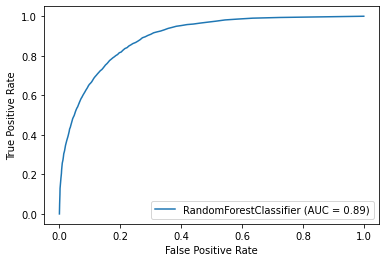

In [57]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(models['Random Forest'], X_test_df, y_test);

- y axis = Recall.
- x axis = False Positive Rate. 

The FPR is not precision, but it can still be useful:
    
    - Precision = true positives / total positive predictions.
    - False Positive Rate = false positives / total negatives.

---
Now, just choose your threshold from the following list to balance fpr/tpr.

In [60]:
from sklearn.metrics import roc_curve, auc

# For each test X, predict the probability of class 1
rf = models['Random Forest']
pred_proba = [p[1] for p in rf.predict_proba(X_test_df)]

# Compute ROC values manually
fpr, tpr, thresholds = roc_curve(y_test,
                                 pred_proba,
                                 pos_label='>50K')

# Compute Area Under the Curve
roc_auc = auc(fpr, tpr)

roc_auc

0.8943579177769319

In [61]:
roc_auc_score(y_test, pred_proba)

NameError: name 'roc_auc_score' is not defined

In [59]:
# NOTE: true positive rate = recall
#      false positive rate = out of all times it was actually negative, what % were FPs?

pd.set_option('display.max_rows', 120)
pd.DataFrame.from_dict({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

,fpr,tpr,thresholds
0,0.000000,0.000000,2.000000
1,0.000704,0.050811,1.000000
2,0.001673,0.097027,0.990000
3,0.002113,0.129189,0.980000
4,0.003697,0.157568,0.970000
5,0.005018,0.181351,0.960000
6,0.006602,0.205135,0.950000
7,0.007218,0.222162,0.940000
8,0.008275,0.239730,0.930000
9,0.009419,0.257297,0.920000


---
<a id="next"></a>
# Next Steps - Possible Ideas

+ Instead of only comparing models using Recall, try using AUC instead. This makes sense because AUC measures how far apart the two classes are in "model space". We ultimately want the classes to be very distinct from each other, so that should work better than just optimizing for Recall alone.
+ We did not attempt to optimize the random forest model. So, we are missing obvious sources of improvement.

    + Immediately, we notice that the random forest model overfits. So, we would want to try pruning the trees or making them have less depth to begin with. We could also use CV to adjust some parameters, since we are given a validation set from the beginning!

+ We relied on the test set exclusively for estimating OOS performance. Instead, it would be nice to get a more accurate estimate with error bounds by using CV.
+ Ideally, to productionalize this we would have it output a CSV with a list of the customers predicted to make >50K.
+ Apply results from the EDA to improve the model. For example, removing non-correlated columns or log-transforming the results might improve the usability of the features.


So far, I would choose random forest with the slight improvement from oversampling.